# VL8-Analyse: Flüchtlingsdaten 2006–2016

Dieses Notebook wendet die Methoden aus **Vorlesung 8 (Hypothesentests II)** an.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True

Imports erledigt.


## 1. Daten laden

In [2]:

csv_path = '../../output_csv_files/Origin_country_refugee_flow.csv'

df = pd.read_csv(csv_path)
df.head()

,Origin,Year,Value
0,Afghanistan,1979,500000.0
1,Afghanistan,1980,1734921.0
2,Afghanistan,1981,3879984.0
3,Afghanistan,1982,4488214.0
4,Afghanistan,1983,4712735.0


In [3]:
# Sicherstellen, dass die Spalten die richtigen Typen haben
df.columns = [c.strip() for c in df.columns]

if 'Year' not in df.columns or 'Value' not in df.columns:
    raise ValueError('Erwartete Spalten: Year, Value. Bitte CSV prüfen.')

df['Year'] = df['Year'].astype(int)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df = df.dropna(subset=['Value'])

df.describe(include='all')

,Origin,Year,Value
count,6289,6289.000000,6.289000e+03
unique,222,NaN,NaN
top,Various/Unknown,NaN,NaN
freq,66,NaN,NaN
mean,NaN,1999.215933,8.737617e+04
std,NaN,12.156454,3.697381e+05
min,NaN,1951.000000,0.000000e+00
25%,NaN,1992.000000,6.100000e+01
50%,NaN,2001.000000,1.084000e+03
75%,NaN,2009.000000,2.139600e+04


## 2. Globale Zeitreihe 2006–2016

In [4]:
start_year = 2006
end_year = 2016

df_period = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)].copy()

# Globale Summe pro Jahr
global_ts = df_period.groupby('Year')['Value'].sum().sort_index()
global_ts

Year
2006    10618994.0
2007    12132040.0
2008    11314855.0
2009    11385707.0
2010    11387126.0
2011    11301825.0
2012    11440754.0
2013    12863728.0
2014    16189781.0
2015    19336251.0
2016    19900103.0
Name: Value, dtype: float64

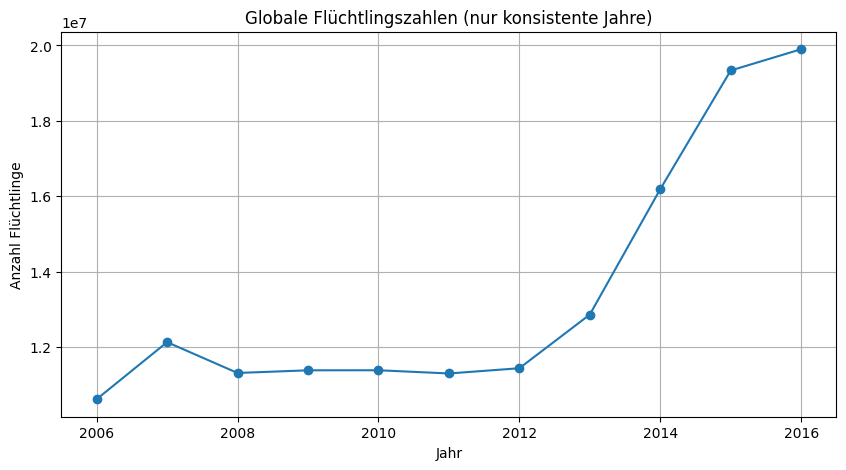

In [5]:
plt.plot(global_ts.index, global_ts.values, marker='o')
plt.title('Globale Flüchtlingszahlen (nur konsistente Jahre)')
plt.xlabel('Jahr')
plt.ylabel('Anzahl Flüchtlinge')
plt.show()

## 3. Frühe vs. spätere Jahre definieren (A/B-Setup)

Wir teilen den Zeitraum in zwei Gruppen:
- **früher**: 2006–2010
- **später**: 2011–2016

In [6]:
early_years = list(range(2006, 2011))
late_years = list(range(2011, 2017))

early_ts = global_ts[global_ts.index.isin(early_years)]
late_ts = global_ts[global_ts.index.isin(late_years)]

print('Frühe Jahre:')
display(early_ts)
print('\nSpätere Jahre:')
display(late_ts)

Frühe Jahre:


Year
2006    10618994.0
2007    12132040.0
2008    11314855.0
2009    11385707.0
2010    11387126.0
Name: Value, dtype: float64


Spätere Jahre:


Year
2011    11301825.0
2012    11440754.0
2013    12863728.0
2014    16189781.0
2015    19336251.0
2016    19900103.0
Name: Value, dtype: float64

## 4. Permutationstest: Sind frühere Jahre > spätere Jahre?

In [7]:
obs_diff = early_ts.mean() - late_ts.mean()
obs_diff

np.float64(-3804329.2666666657)

In [8]:
n_perm = 5000
all_values = np.concatenate([early_ts.values, late_ts.values])
n_early = len(early_ts)

diffs = np.empty(n_perm)
rng = np.random.default_rng(42)

for i in range(n_perm):
    rng.shuffle(all_values)
    early_star = all_values[:n_early]
    late_star = all_values[n_early:]
    diffs[i] = early_star.mean() - late_star.mean()

# zweiseitiger p-Wert
p_value = np.mean(np.abs(diffs) >= np.abs(obs_diff))

obs_diff, p_value

(np.float64(-3804329.2666666657), np.float64(0.0758))

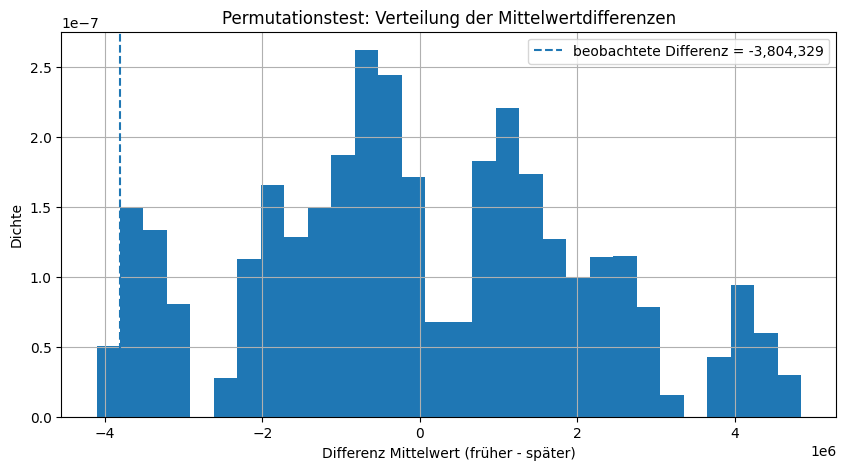

In [9]:
plt.hist(diffs, bins=30, density=True)
plt.axvline(obs_diff, linestyle='--', label=f'beobachtete Differenz = {obs_diff:,.0f}')
plt.title('Permutationstest: Verteilung der Mittelwertdifferenzen')
plt.xlabel('Differenz Mittelwert (früher - später)')
plt.ylabel('Dichte')
plt.legend()
plt.show()

## 5. Cohen's d: Effektgrösse für Mittelwerte

In [10]:
def cohens_d(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    nx, ny = len(x), len(y)
    sx2 = np.var(x, ddof=1)
    sy2 = np.var(y, ddof=1)
    s_pooled = np.sqrt(((nx - 1) * sx2 + (ny - 1) * sy2) / (nx + ny - 2))
    return (np.mean(y) - np.mean(x)) / s_pooled

d = cohens_d(early_ts.values, late_ts.values)
d

np.float64(1.3082245780738693)

## 6. χ²-Test: Hohe vs. niedrige Flüchtlingsjahre früher vs. später

Wir teilen die Jahre in **hoch** / **niedrig** auf Basis der globalen Verteilung.

In [11]:
# Schwelle: Median der globalen Summe pro Jahr
threshold = global_ts.median()
threshold

np.float64(11440754.0)

In [12]:
cat = pd.DataFrame({'Year': global_ts.index, 'Refugees': global_ts.values})
cat['period'] = np.where(cat['Year'].isin(early_years), 'early', 'late')
cat['level'] = np.where(cat['Refugees'] >= threshold, 'high', 'low')
cat

,Year,Refugees,period,level
0,2006,10618994.0,early,low
1,2007,12132040.0,early,high
2,2008,11314855.0,early,low
3,2009,11385707.0,early,low
4,2010,11387126.0,early,low
5,2011,11301825.0,late,low
6,2012,11440754.0,late,high
7,2013,12863728.0,late,high
8,2014,16189781.0,late,high
9,2015,19336251.0,late,high


In [13]:
ct = pd.crosstab(cat['period'], cat['level'])
ct

level,high,low
period,,
early,1,4
late,5,1


In [14]:
chi2, p_chi2, dof, expected = stats.chi2_contingency(ct)
chi2, p_chi2, dof, expected

(np.float64(2.2274999999999996),
 np.float64(0.1355730537509376),
 1,
 array([[2.72727273, 2.27272727],
        [3.27272727, 2.72727273]]))

## 7. Risk Ratio (RR) und Odds Ratio (OR)

In [15]:
# Wir nehmen 'high' als Ereignis
a = ct.loc['early', 'high']
b = ct.loc['early', 'low']
c = ct.loc['late', 'high']
d = ct.loc['late', 'low']

risk_early = a / (a + b)
risk_late = c / (c + d)
rr = risk_early / risk_late if risk_late > 0 else np.nan

odds_early = a / b if b > 0 else np.nan
odds_late = c / d if d > 0 else np.nan
or_ = odds_early / odds_late if odds_late > 0 else np.nan

risk_early, risk_late, rr, odds_early, odds_late, or_

(np.float64(0.2),
 np.float64(0.8333333333333334),
 np.float64(0.24),
 np.float64(0.25),
 np.float64(5.0),
 np.float64(0.05))

# Permutationstest

Beobachtete Differenz (früh - spät): -3804329.2666666657
Permutation p-Wert: 0.0758


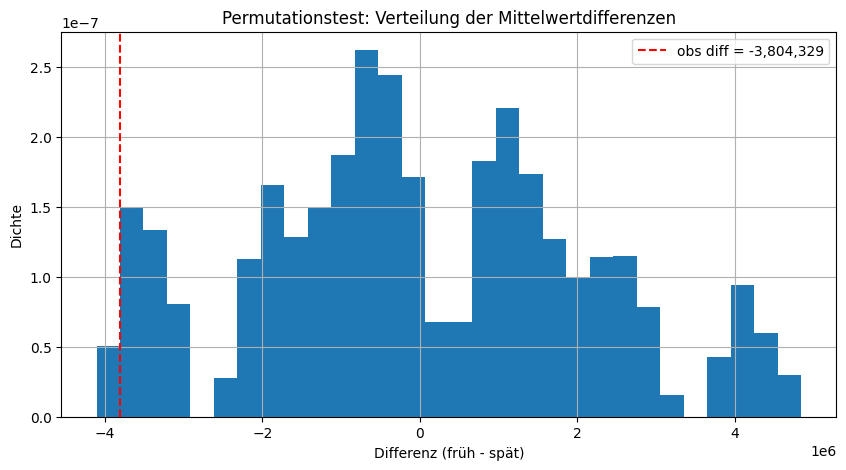

In [ ]:


import numpy as np

# Beobachtete Differenz
obs_diff = early_ts.mean() - late_ts.mean()
print("Beobachtete Differenz (früh - spät):", obs_diff)

# Permutationstest
n_perm = 5000
all_values = np.concatenate([early_ts.values, late_ts.values])
n_early = len(early_ts)

rng = np.random.default_rng(42)
perm_diffs = np.empty(n_perm)

for i in range(n_perm):
    rng.shuffle(all_values)
    early_star = all_values[:n_early]
    late_star = all_values[n_early:]
    perm_diffs[i] = early_star.mean() - late_star.mean()

# zweiseitiger p-Wert
p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))

print("Permutation p-Wert:", p_value)

plt.hist(perm_diffs, bins=30, density=True)
plt.axvline(obs_diff, color='red', linestyle='--', label=f"obs diff = {obs_diff:,.0f}")
plt.title("Permutationstest: Verteilung der Mittelwertdifferenzen")
plt.xlabel("Differenz (früh - spät)")
plt.ylabel("Dichte")
plt.legend()
plt.show()